# 영화 추천 시스템 만들기

### MovieLens 1M Dataset

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한, 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.


### Exploration 9번 프로젝트 평가 기준

| |평가문항|상세기준|
|------|---|---|
|1|CSR matrix가 정상적으로 만들어졌다.|사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.|
|2|MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.|사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.|
|3|비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.|MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.|

# Data Info
MovieLens에 가입한 사람들의 영화 평점 평가 정보가 포함되어 있습니다. 2000년에 MovieLens에 가입한 6,040명의 MovieLens 사용자가 만든 약 3,900개의 영화에 대한 약 1백만 개의 익명 등급이 포함되어 있습니다.

## Summary
movies: 3,900
rating: 1,000,209
user: 6,040

## RATINGS FILE DESCRIPTION
모든 평점은 "ratings.dat" 파일에 포함되어 있으며, 아래와 같은 형식입니다.

UserID::MovieID::Rating::Timestamp

   - User ID: 6,040
   - Movie ID: 3952
   - rating: 1~5 point
   - Timestamp: time(2)에 반환된 epoch(sec)
   - 각 사용자는 최소 20개의 평가를 가졌음
   
## USERS FILE DESCRIPTION
사용자 정보는 "users.dat" 파일에 포함되어 있으며, 아래와 같은 형식입니다.

UserID::Gender::Age::Occupation::Zip-code

   - 성별: 남성은 "M", 여성은 "F"
   - 연령은 범주형 데이터
       *  1:  "Under 18"
       * 18:  "18-24"
       * 25:  "25-34"
       * 35:  "35-44"
       * 45:  "45-49"
       * 50:  "50-55"
       * 56:  "56+"
       
   - 직업은 다음 중 선택 옵션
        *  0:  "other" or not specified
        *  1:  "academic/educator"
        *  2:  "artist"
        *  3:  "clerical/admin"
        *  4:  "college/grad student"
        *  5:  "customer service"
        *  6:  "doctor/health care"
        *  7:  "executive/managerial"
        *  8:  "farmer"
        *  9:  "homemaker"
        * 10:  "K-12 student"
        * 11:  "lawyer"
        * 12:  "programmer"
        * 13:  "retired"
        * 14:  "sales/marketing"
        * 15:  "scientist"
        * 16:  "self-employed"
        * 17:  "technician/engineer"
        * 18:  "tradesman/craftsman"
        * 19:  "unemployed"
        * 20:  "writer"

## MOVIES FILE DESCRIPTION
영화 정보는 "movies.dat" 파일에 포함되어 있으며, 아래와 같은 형식입니다.

MovieID::Title::Genres

   - 제목은 IMDB에서 제공하는 제목과 동일합니다.
   - 장르는 pipe로 구분됩니다.
       * Action
       * Adventure
       * Animation
       * Children's
       * Comedy
       * Crime
       * Documentary
       * Drama
       * Fantasy
       * Film-Noir
       * Horror
       * Musical
       * Mystery
       * Romance
       * Sci-Fi
       * Thriller
       * War
       * Western
       
## 전처리가 필요한 부분?
- 일부 Movie ID는 중복되어 있을 수 있다.
- 영화 이름에 오류가 있을 수 있다.

# 1. 데이터 로드 및 전처리

In [611]:
pip install LightFM

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [612]:
from scipy import sparse
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [613]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Ratings file load

In [614]:
file_path = os.getenv('HOME')+ '/aiffel/recommendata_iu/data/ml-1m'
rating_file_path=os.path.join(file_path, 'ratings.dat')

ratings_cols = ['User_ID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_csv(rating_file_path, sep='::',
                      names=ratings_cols,
                      engine='python',
                      encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,User_ID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Movies file load

In [615]:
movies_file_path=os.path.join(file_path, 'movies.dat')
movies_cols = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv(movies_file_path,
                     sep = "::",
                     names = movies_cols,
                     encoding='latin-1',
                     engine='python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Users file load

In [616]:
users_file_path = os.path.join(file_path, 'users.dat')
users_col = ['User_ID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users = pd.read_csv(users_file_path,
                    sep = "::",
                    names = users_col,
                    engine='python')
users.head()

,User_ID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## 평점 3점 이하는 삭제
유저에게 영화를 추천하는 시스템을 만들 예정이라, 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외합니다.

In [617]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['Rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


## 컬럼명 변경

In [618]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'Rating':'Count'}, inplace=True)

In [619]:
ratings['Count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: Count, Length: 836478, dtype: int64

## 여러 가지 장르 구분해주기

In [620]:
movies['Genres'].nunique()

301

이 데이터셋의 영화 장르는 18가지인데, 실제 영화 장르 수를 조회해주면 301개나 조회가 됩니다.😨 왜일까요?

In [621]:
movies['Genres'].head()

0     Animation|Children's|Comedy
1    Adventure|Children's|Fantasy
2                  Comedy|Romance
3                    Comedy|Drama
4                          Comedy
Name: Genres, dtype: object

'Genres' 컬럼을 head를 통해 5개만 확인해보니, 한 가지의 장르만 대표하는 영화도 있고 여러 가지 장르가 섞인 영화도 있습니다. 이는 '|' pipe가 구분값으로 여러 가지 장르가 섞여 있기 때문에 이를 split 해주려고 합니다.

In [622]:
max(movies['Genres'], key=len)

"Action|Animation|Children's|Sci-Fi|Thriller|War"

최대 장르 수를 확인하기 위한 정확한 방법은 아닙니다.🙅‍ 하지만 간단하게 조회해보자고요. 장르 컬럼에서 가장 긴 글자 수를 조회해보니 6가지 장르가 섞여 있습니다. 이를 기준으로, Genre 1~6까지 새로운 컬럼을 추가해줍니다.

In [623]:
movies[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6']] = movies.Genres.str.split("|",expand=True)
movies.head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure,Children's,Fantasy,None,None,None
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,None,None,None,None
3,4,Waiting to Exhale (1995),Comedy|Drama,Comedy,Drama,None,None,None,None
4,5,Father of the Bride Part II (1995),Comedy,Comedy,None,None,None,None,None


'Genre1~6'까지 새로운 컬럼이 생성되었지만, 일단 'Genres' 컬럼은 따로 삭제하진 않겠습니다.

## Movies와 Ratings file을 Merge

In [704]:
movieset = pd.merge(movies, ratings, on = 'MovieID')

In [705]:
movieset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 836477
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   MovieID    836478 non-null  int64 
 1   Title      836478 non-null  object
 2   Genres     836478 non-null  object
 3   Genre 1    836478 non-null  object
 4   Genre 2    576693 non-null  object
 5   Genre 3    254936 non-null  object
 6   Genre 4    78184 non-null   object
 7   Genre 5    11522 non-null   object
 8   Genre 6    175 non-null     object
 9   User_ID    836478 non-null  int64 
 10  Count      836478 non-null  int64 
 11  Timestamp  836478 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 83.0+ MB


In [706]:
movieset.head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,10,5,978226474


In [707]:
movieset.tail()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
836473,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5682,3,1029457829
836474,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5812,4,992072099
836475,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5831,3,986223125
836476,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5837,4,1011902656
836477,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5998,4,1001781044


## 중복 데이터 조회하기

In [708]:
movieset[movieset.duplicated()]

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp


중복된 데이터가 하나도 없군요. Dataset이 엄청 clear~하네요🌈

## 이상값 조회

In [709]:
movieset[movieset['Count'] > 5]

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp


In [710]:
movieset[movieset['Count'] < 3]

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp


평점이 1~5점까지고, 3점 미만 점수는 다 버렸으니 아무 데이터도 조회되지 않는 것이 정상입니다!

## 모델에 활용하기 위한 전처리

In [777]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = movieset['User_ID'].unique()
movie_unique = movieset['MovieID'].unique()

# 유저, 영화를 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [780]:
temp_user_data = movieset['User_ID'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(movieset):
    print('user_id column indexing OK!!')
    movieset['User_ID'] = temp_user_data   
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 Title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = movieset['MovieID'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(movieset):
    print('MovieID column indexing OK!!')
    movieset['MovieID'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

movieset

user_id column indexing OK!!
MovieID column indexing OK!!


,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
0,0,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,0,5,978824268.0
1,0,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,1,4,978237008.0
2,0,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,2,4,978233496.0
3,0,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,3,5,978225952.0
4,0,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,4,5,978226474.0
...,...,...,...,...,...,...,...,...,...,...,...,...
0,3628,Avatar (2009),Action|Adventure|Sci-Fi,Action,Adventure,Sci-Fi,None,None,None,6039,3,NaN
1,3629,La La Land (2016),Romance|Musical,Romance,Musical,None,None,None,None,6039,5,NaN
2,3630,Inception (2010),Sci-Fi|Action,Sci-Fi,Action,None,None,None,None,6039,3,NaN
3,3631,Parasite (2019),Drama,Drama,None,None,None,None,None,6039,5,NaN


# 2. 데이터 탐색 및 시각화

- ratings에 있는 유니크한 영화 개수
- rating에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [715]:
# 영화 갯수
movieset['MovieID'].nunique()

3628

In [716]:
# 사용자 수
movieset['User_ID'].nunique()

6039

In [717]:
print(movieset['Genre 1'].count())
print(movieset['Genre 2'].count())
print(movieset['Genre 3'].count())
print(movieset['Genre 4'].count())
print(movieset['Genre 5'].count())
print(movieset['Genre 6'].count())

836478
576693
254936
78184
11522
175


Genre를 확인해보니 세 번째까지만 조회해보아도 될 것 같습니다.

In [718]:
most_genre_1st = movieset['Genre 1'].value_counts()
most_genre_1st

Comedy         229933
Action         209494
Drama          184916
Adventure       35078
Crime           34271
Animation       32455
Horror          30372
Children's      16480
Thriller        14925
Mystery          9214
Sci-Fi           8876
Film-Noir        8839
Musical          6381
Documentary      6187
Western          5221
Romance          2312
War               924
Fantasy           600
Name: Genre 1, dtype: int64

In [719]:
most_genre_2nd = movieset['Genre 2'].value_counts()
most_genre_2nd

Drama          102762
Romance         86100
Adventure       73740
Thriller        66933
Sci-Fi          55176
Children's      39008
Comedy          36892
Crime           25701
War             21973
Horror          20048
Mystery         16335
Fantasy          8718
Musical          8223
Film-Noir        5409
Western          4475
Animation        4225
Documentary       975
Name: Genre 2, dtype: int64

In [720]:
most_genre_3rd = movieset['Genre 3'].value_counts()
most_genre_3rd

Thriller      49285
Sci-Fi        40412
Romance       28874
War           27620
Comedy        26140
Drama         20622
Fantasy       17027
Musical       14154
Mystery        8386
Crime          7020
Western        6864
Film-Noir      2918
Horror         2579
Children's     2106
Animation       929
Name: Genre 3, dtype: int64

Comedy, Action, Drama, Romance, Adventure 이 다섯 가지 종류가 가장 많네요!

In [721]:
# 유저별 관란함 영화 수
user_count = movieset.groupby('User_ID')['MovieID'].count()
user_count.sort_values(ascending=False).head(30)

User_ID
4169    1968
4277    1715
1680    1515
3618    1146
1015    1145
5831    1136
2909    1119
1941    1116
424     1106
1980    1054
1285    1034
3224    1034
3539    1029
3391    1012
3032    1003
1181     981
3841     976
4344     973
4448     970
1088     966
549      956
889      943
4725     936
678      933
1448     930
2063     906
3292     897
1698     883
4808     868
2116     855
Name: MovieID, dtype: int64

In [722]:
# 유저별 관람수 통계 요약
user_ds = user_count.describe()
print(user_ds)

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: MovieID, dtype: float64


In [723]:
# User_ID 가 1인 사람이 본 영화 list
exam_user = (movieset['User_ID']== movieset.loc[0, 'User_ID'])
movieset.loc[exam_user]

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,1,5,978824268
19773,48,Pocahontas (1995),Animation|Children's|Musical|Romance,Animation,Children's,Musical,Romance,None,None,1,5,978824351
35123,150,Apollo 13 (1995),Drama,Drama,None,None,None,None,None,1,5,978301777
54895,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,Action,Adventure,Fantasy,Sci-Fi,None,None,1,4,978300760
116019,527,Schindler's List (1993),Drama|War,Drama,War,None,None,None,None,1,5,978824195
119008,531,"Secret Garden, The (1993)",Children's|Drama,Children's,Drama,None,None,None,None,1,4,978302149
130190,588,Aladdin (1992),Animation|Children's|Comedy|Musical,Animation,Children's,Comedy,Musical,None,None,1,4,978824268
138999,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,Animation,Children's,Musical,None,None,None,1,4,978302268
139706,595,Beauty and the Beast (1991),Animation|Children's|Musical,Animation,Children's,Musical,None,None,None,1,5,978824268
142605,608,Fargo (1996),Crime|Drama|Thriller,Crime,Drama,Thriller,None,None,None,1,4,978301398


In [724]:
len(movieset.loc[exam_user])

53

이 데이터는 각 User마다 20개 이상의 평가를 가져야 한다. 1번 User는 영화 평점을 남긴 수 조회 시 53개가 나온다.

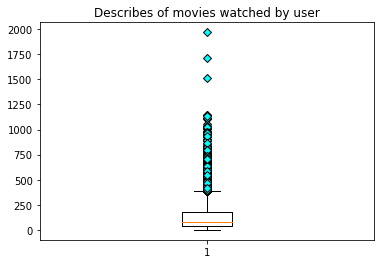

In [725]:
# BoxPlot 으로 확인해보기
green_diamond = dict(markerfacecolor='aqua', marker='D')
plt.boxplot(user_count, flierprops=green_diamond)
plt.title("Describes of movies watched by user")
plt.show()

In [726]:
# 평점별 영화 수
rated_count = movieset['Count'].value_counts()
rated_count

4    348971
3    261197
5    226310
Name: Count, dtype: int64

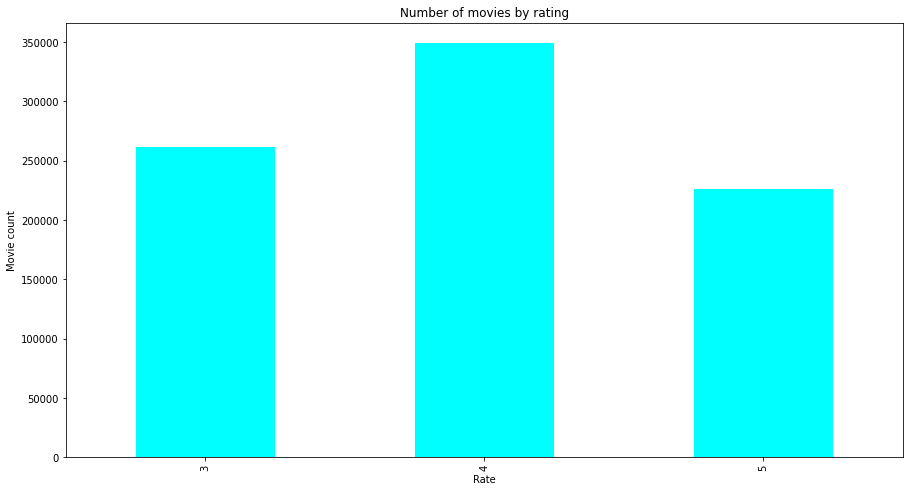

In [727]:
f, ax=plt.subplots(1,1, figsize=(15,8))
rated_count.plot(kind='bar',color= 'aqua', ax=ax,legend=False)
plt.xlabel('Rate')
plt.ylabel('Movie count')
plt.title('Number of movies by rating')
plt.show()

In [728]:
# 가장 인기 있는 영화
most_rated_movies = movieset.groupby('Title').size().sort_values(ascending = False)
most_rated_movies.head()

Title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
dtype: int64

In [729]:
# 평점이 높은 영화 5순위
popular_movies = movieset.groupby('Title')['Count'].mean().sort_values(ascending = False)
popular_movies.head()

Title
Ulysses (Ulisse) (1954)                      5.0
Country Life (1994)                          5.0
Schlafes Bruder (Brother of Sleep) (1995)    5.0
Foreign Student (1994)                       5.0
Follow the Bitch (1998)                      5.0
Name: Count, dtype: float64

In [730]:
# 가장 인기 많은 영화 - MovieID로 조회 (COunt로 조회해도 똑같은 결과가 나온다)
popular_movies_count = movieset.groupby('Title')['MovieID'].count().sort_values(ascending = False)
popular_movies_count.head()

Title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Name: MovieID, dtype: int64

In [731]:
movie_ratings = pd.DataFrame(movieset.groupby('Title')['Count'].mean())
movie_ratings['Number of Ratings'] = movieset.groupby('Title')['Count'].count()
movie_ratings.head()

,Count,Number of Ratings
Title,,
"$1,000,000 Duck (1971)",3.576923,26
'Night Mother (1986),3.785714,56
'Til There Was You (1997),3.518519,27
"'burbs, The (1989)",3.575758,198
...And Justice for All (1979),3.854054,185


In [732]:
popular_movie_ratings = movie_ratings.sort_values(by='Count',ascending = False)
popular_movie_ratings.head()

,Count,Number of Ratings
Title,,
Ulysses (Ulisse) (1954),5.0,1
Country Life (1994),5.0,1
Schlafes Bruder (Brother of Sleep) (1995),5.0,1
Foreign Student (1994),5.0,1
Follow the Bitch (1998),5.0,1


In [733]:
popular_movie_ratings.tail()

,Count,Number of Ratings
Title,,
"War at Home, The (1996)",3.0,1
Frogs for Snakes (1998),3.0,2
Chain of Fools (2000),3.0,1
Avalanche (1978),3.0,12
Number Seventeen (1932),3.0,1


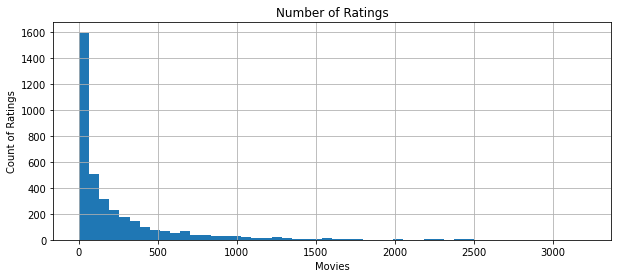

In [734]:
plt.figure(figsize = (10, 4))
movie_ratings['Number of Ratings'].hist(bins = 50)
plt.xlabel('Movies')
plt.ylabel('Count of Ratings')
plt.title('Number of Ratings')
plt.show()

<AxesSubplot:>

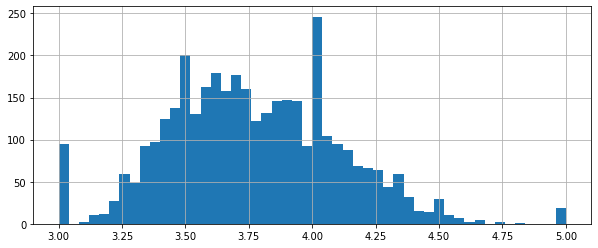

In [735]:
plt.figure(figsize = (10, 4))
movie_ratings['Count'].hist(bins = 50)

# 3. 내가 선호하는 영화 5가지 추가하기
rating에 추가하기

In [736]:
movieset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 836477
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   MovieID    836478 non-null  int64 
 1   Title      836478 non-null  object
 2   Genres     836478 non-null  object
 3   Genre 1    836478 non-null  object
 4   Genre 2    576693 non-null  object
 5   Genre 3    254936 non-null  object
 6   Genre 4    78184 non-null   object
 7   Genre 5    11522 non-null   object
 8   Genre 6    175 non-null     object
 9   User_ID    836478 non-null  int64 
 10  Count      836478 non-null  int64 
 11  Timestamp  836478 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 115.2+ MB


In [737]:
movieset[movieset['Title'].str.contains('Star')].head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
33045,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,345,4,976335143
33046,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,352,5,976332130
33047,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,568,5,976028625
33048,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,1150,3,974874113
33049,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,3475,3,1015738441


movieset에서 Title에 'Star'을 포함하는 문자열을 조회하니 해당 값들이 조회가 되네요! 그럼 제가 좋아하는 영화 5개 추가를 위해서 영화 이름을 조회해주는 함수를 만들어보겠습니다.

In [738]:
# 영화 이름 조회 함수
def find_movies(movie_name):
    movieset[movieset['Title'].str.contains(movie_name)]
    return movieset[movieset['Title'].str.contains(movie_name)]

In [739]:
find_movies('Star')

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
33045,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,345,4,976335143
33046,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,352,5,976332130
33047,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,568,5,976028625
33048,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,1150,3,974874113
33049,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama,None,None,None,None,None,3475,3,1015738441
...,...,...,...,...,...,...,...,...,...,...,...,...
801629,3699,Starman (1984),Adventure|Drama|Romance|Sci-Fi,Adventure,Drama,Romance,Sci-Fi,None,None,5787,4,984189976
801630,3699,Starman (1984),Adventure|Drama|Romance|Sci-Fi,Adventure,Drama,Romance,Sci-Fi,None,None,5812,4,960875940
801631,3699,Starman (1984),Adventure|Drama|Romance|Sci-Fi,Adventure,Drama,Romance,Sci-Fi,None,None,5831,4,978036885
801632,3699,Starman (1984),Adventure|Drama|Romance|Sci-Fi,Adventure,Drama,Romance,Sci-Fi,None,None,5996,3,1020097667


In [740]:
# 영화 이름 조회 함수
def find_movies(movie_name):
    movieset[movieset['Title'].str.contains(movie_name)]
    return movieset[movieset['Title'].str.contains(movie_name)]

In [741]:
# 영화 '아바타'
find_movies('Avatar').head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp


In [742]:
# 영화 '라라랜드'
find_movies('la land').head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp


In [743]:
# 영화 '다크 나이트'
find_movies('Dark Knight').head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp


In [744]:
# 영화 '시네마천국'
find_movies('Cinema').head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
243118,1172,Cinema Paradiso (1988),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,35,4,978100951
243119,1172,Cinema Paradiso (1988),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,36,5,978063192
243120,1172,Cinema Paradiso (1988),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,59,4,1041962943
243121,1172,Cinema Paradiso (1988),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,62,4,977928570
243122,1172,Cinema Paradiso (1988),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,88,5,977696617


In [745]:
# 영화 '사운드 오브 뮤직'
find_movies('Music').head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
164742,791,"Last Klezmer: Leopold Kozlowski, His Life and ...",Documentary,Documentary,None,None,None,None,None,3367,3,970080151
164743,791,"Last Klezmer: Leopold Kozlowski, His Life and ...",Documentary,Documentary,None,None,None,None,None,5147,4,962022697
210912,1035,"Sound of Music, The (1965)",Musical,Musical,None,None,None,None,None,1,5,978301753
210913,1035,"Sound of Music, The (1965)",Musical,Musical,None,None,None,None,None,6,5,978237767
210914,1035,"Sound of Music, The (1965)",Musical,Musical,None,None,None,None,None,10,5,979775485


- '아바타', '라라랜드', '다크나이트'는 2000년 이후 나온 영화라 조회가 되지 않고, '시네마천국'이나 '사운드 오브 뮤직' 같은 오래된 영화는 이미 조회가 되고 있군요!
- 저는 추가로 한국 영화 2개를 더 추가해주겠습니다. 저는 '기생충(Parasite)'과 '아가씨(The Handmaiden)'를 추가하겠습니다.

In [746]:
find_movies('Parasite').head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
517876,2256,Parasite (1982),Horror|Sci-Fi,Horror,Sci-Fi,None,None,None,None,549,4,976117191
517877,2256,Parasite (1982),Horror|Sci-Fi,Horror,Sci-Fi,None,None,None,None,850,3,975359595
517878,2256,Parasite (1982),Horror|Sci-Fi,Horror,Sci-Fi,None,None,None,None,1680,4,974709135
517879,2256,Parasite (1982),Horror|Sci-Fi,Horror,Sci-Fi,None,None,None,None,1722,3,974707978
517880,2256,Parasite (1982),Horror|Sci-Fi,Horror,Sci-Fi,None,None,None,None,1761,3,974703434


In [747]:
find_movies('Handmaiden').head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp


순간 'Parasite'가 조회가 돼서 놀랐지만, 괄호 안에 년도를 보니 다른 영화입니다. 그러면 이제 Title 규칙에 맞게 한 번 추가해보겠습니다.

- Avatar (2009)
- La La Land (2016)
- Inception (2010)
- Parasite (2019)
- The Handmaiden (2016)

In [748]:
movieset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 836477
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   MovieID    836478 non-null  int64 
 1   Title      836478 non-null  object
 2   Genres     836478 non-null  object
 3   Genre 1    836478 non-null  object
 4   Genre 2    576693 non-null  object
 5   Genre 3    254936 non-null  object
 6   Genre 4    78184 non-null   object
 7   Genre 5    11522 non-null   object
 8   Genre 6    175 non-null     object
 9   User_ID    836478 non-null  int64 
 10  Count      836478 non-null  int64 
 11  Timestamp  836478 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 115.2+ MB


In [749]:
movieset['User_ID'].max()

6040

In [750]:
movieset['MovieID'].max()

3952

In [751]:
movieset.columns

Index(['MovieID', 'Title', 'Genres', 'Genre 1', 'Genre 2', 'Genre 3',
       'Genre 4', 'Genre 5', 'Genre 6', 'User_ID', 'Count', 'Timestamp'],
      dtype='object')

In [752]:
# 영화 목록 5개 추가
my_favorite = ['Avatar (2009)',
               'La La Land (2016)',
               'Inception (2010)',
               'Parasite (2019)',
               'The Handmaiden (2016)']

In [753]:
# 영화 목록 5개 추가
my_favorite = ['Avatar (2009)',
               'La La Land (2016)',
               'Inception (2010)',
               'Parasite (2019)',
               'The Handmaiden (2016)']

my_index = [3953, 3954, 3955, 3956, 3957]
my_id = 6041

# movieset에 넣기 위한 columns 지정
my_movielist = pd.DataFrame({'MovieID': my_index,
                            'Title': my_favorite,
                            'Genres': ['Action|Adventure|Sci-Fi','Romance|Musical','Sci-Fi|Action','Drama','Thriller|Drama'],
                            'User_ID': my_id,
                            'Count':[3, 5, 3, 5, 4]})

my_movielist

,MovieID,Title,Genres,User_ID,Count
0,3953,Avatar (2009),Action|Adventure|Sci-Fi,6041,3
1,3954,La La Land (2016),Romance|Musical,6041,5
2,3955,Inception (2010),Sci-Fi|Action,6041,3
3,3956,Parasite (2019),Drama,6041,5
4,3957,The Handmaiden (2016),Thriller|Drama,6041,4


In [754]:
movieset = movieset.append(my_movielist)
movieset[['Genre 1', 'Genre 2', 'Genre 3','Genre 4', 'Genre 5', 'Genre 6']] = movieset.Genres.str.split("|",expand=True)
movieset.tail(10)

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
836473,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5682,3,1.029458e+09
836474,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5812,4,9.920721e+08
836475,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5831,3,9.862231e+08
836476,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5837,4,1.011903e+09
836477,3952,"Contender, The (2000)",Drama|Thriller,Drama,Thriller,None,None,None,None,5998,4,1.001781e+09
0,3953,Avatar (2009),Action|Adventure|Sci-Fi,Action,Adventure,Sci-Fi,None,None,None,6041,3,NaN
1,3954,La La Land (2016),Romance|Musical,Romance,Musical,None,None,None,None,6041,5,NaN
2,3955,Inception (2010),Sci-Fi|Action,Sci-Fi,Action,None,None,None,None,6041,3,NaN
3,3956,Parasite (2019),Drama,Drama,None,None,None,None,None,6041,5,NaN
4,3957,The Handmaiden (2016),Thriller|Drama,Thriller,Drama,None,None,None,None,6041,4,NaN


In [755]:
movieset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836483 entries, 0 to 4
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MovieID    836483 non-null  int64  
 1   Title      836483 non-null  object 
 2   Genres     836483 non-null  object 
 3   Genre 1    836483 non-null  object 
 4   Genre 2    576697 non-null  object 
 5   Genre 3    254937 non-null  object 
 6   Genre 4    78184 non-null   object 
 7   Genre 5    11522 non-null   object 
 8   Genre 6    175 non-null     object 
 9   User_ID    836483 non-null  int64  
 10  Count      836483 non-null  int64  
 11  Timestamp  836478 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 83.0+ MB


추가한 제 정보가 5개 추가되었습니다. movieset에 잘 저장이 되었습니다!

# 4. CSR matrix 만들기

In [756]:
from scipy.sparse import csr_matrix

In [757]:
indptr = [ 0, 5, 8, 11]
indices = [0, 1, 2, 3, 4, 3, 1, 5, 0, 1, 6 ]
data = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

term_document_csr_mat = csr_matrix((data, indices, indptr), dtype=int)
term_document_csr_mat

<3x7 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [758]:
term_document_arr = term_document_csr_mat.toarray()
term_document_arr

array([[1, 1, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 1]])

In [759]:
num_user = movieset['User_ID'].nunique()
num_movie = movieset['MovieID'].nunique()

print(num_user)
print(num_movie)

6040
3633


In [760]:
movieset.Count.nunique()

3

In [761]:
movieset.Count

0    5
1    4
2    4
3    5
4    5
    ..
0    3
1    5
2    3
3    5
4    4
Name: Count, Length: 836483, dtype: int64

In [762]:
movieset.User_ID

0       1
1       6
2       8
3       9
4      10
     ... 
0    6041
1    6041
2    6041
3    6041
4    6041
Name: User_ID, Length: 836483, dtype: int64

In [763]:
movieset.MovieID

0       1
1       1
2       1
3       1
4       1
     ... 
0    3953
1    3954
2    3955
3    3956
4    3957
Name: MovieID, Length: 836483, dtype: int64

In [764]:
csr_data = csr_matrix((movieset.Count, (movieset.User_ID, movieset.MovieID)))
csr_data

<6042x3958 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [765]:
csr_data.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 5, 4]], dtype=int64)

In [766]:
csr_data.toarray().shape

(6042, 3958)

# 5. als_model = AlternatingLeastSquares 모델 및 학습

In [767]:
from implicit.als import AlternatingLeastSquares

In [768]:
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [769]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=1000, regularization=0.01,
                                    use_gpu=False, iterations=15, dtype=np.float32)

In [770]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3958x6042 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [771]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 6. 모델이 예측한 나의 선호도 파악
내가 선호하는 5가지 영화(my_favorite) 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해보기

In [772]:
find_movies('Land').tail()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
433558,1898,"Land Girls, The (1998)",Drama|War,Drama,War,None,None,None,None,4957,3,962908557.0
433559,1898,"Land Girls, The (1998)",Drama|War,Drama,War,None,None,None,None,5680,5,958612583.0
433560,1898,"Land Girls, The (1998)",Drama|War,Drama,War,None,None,None,None,5812,4,957943857.0
433561,1898,"Land Girls, The (1998)",Drama|War,Drama,War,None,None,None,None,5831,4,957889393.0
1,3954,La La Land (2016),Romance|Musical,Romance,Musical,None,None,None,None,6041,5,NaN


In [773]:
find_movies('Music').head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
164742,791,"Last Klezmer: Leopold Kozlowski, His Life and ...",Documentary,Documentary,None,None,None,None,None,3367,3,970080151.0
164743,791,"Last Klezmer: Leopold Kozlowski, His Life and ...",Documentary,Documentary,None,None,None,None,None,5147,4,962022697.0
210912,1035,"Sound of Music, The (1965)",Musical,Musical,None,None,None,None,None,1,5,978301753.0
210913,1035,"Sound of Music, The (1965)",Musical,Musical,None,None,None,None,None,6,5,978237767.0
210914,1035,"Sound of Music, The (1965)",Musical,Musical,None,None,None,None,None,10,5,979775485.0


In [781]:
LaLa_Land = movie_to_idx[3954]
LaLa_Land

3629

In [782]:
Sound_of_Music = movie_to_idx[1035]
Sound_of_Music

948

In [783]:
LaLa_Land_vector, Sound_of_Music_vector = als_model.user_factors[my_id], als_model.item_factors[Sound_of_Music]

print('슝=3')

슝=3


In [784]:
LaLa_Land_vector

array([-1.88298132e-02, -4.80662622e-02,  1.18226595e-01, -6.29098490e-02,
       -1.15557522e-01,  1.56974286e-01, -2.33151186e-02,  9.05105621e-02,
        8.32554027e-02,  7.35263005e-02, -1.44811183e-01,  1.18851647e-01,
        1.15482081e-02, -2.57786233e-02,  5.91429099e-02,  4.80097495e-02,
        2.22413912e-01,  3.08696888e-02, -1.88318156e-02,  1.16808705e-01,
       -2.57586781e-02,  1.46659613e-01, -8.37254599e-02,  6.88247457e-02,
       -9.19336081e-02, -1.62257999e-01, -2.29481887e-02,  1.19664147e-01,
       -1.36906104e-02, -4.10604812e-02, -1.17339902e-01,  3.59482993e-03,
       -3.26578557e-01,  1.07623987e-01, -3.73674780e-02, -4.87641320e-02,
        2.40674503e-02, -2.65947860e-02, -4.44973633e-02,  4.34678532e-02,
       -5.10126129e-02, -1.06228925e-01, -6.49050549e-02, -6.53980449e-02,
       -6.79458901e-02, -2.50592846e-02,  1.09184980e-01, -1.43615529e-02,
       -2.51323897e-02, -1.02815256e-01, -1.10783055e-02, -2.26472467e-02,
        1.85036719e-01, -

In [785]:
Sound_of_Music_vector

array([ 1.38186775e-02,  1.97570212e-03,  7.83580914e-03,  1.07087195e-02,
        4.97059245e-03,  2.92443833e-03,  3.30848666e-03,  5.23320399e-03,
        1.61368505e-03,  2.88483175e-03,  6.45265542e-03,  1.01135140e-02,
        1.23155173e-02, -1.84318880e-04, -2.17633252e-03,  2.00206158e-03,
       -1.41325535e-03,  4.68423124e-03,  2.75595812e-04,  6.34444738e-03,
       -2.73404503e-03, -6.09076465e-04,  8.31243116e-03,  4.82877763e-03,
        1.27258319e-02,  5.20764804e-03,  7.54946610e-03, -2.02140445e-03,
        6.49640476e-03,  7.21556926e-03,  9.67383943e-03,  6.07997365e-03,
        7.99883809e-03,  5.62266354e-03,  1.15983728e-02,  8.43086280e-03,
       -4.69563343e-03,  4.25444078e-03,  1.78572861e-03,  6.82931440e-03,
        2.47444725e-03,  2.06713774e-03,  1.15911791e-03,  9.54503752e-03,
        2.17920344e-04,  1.13805467e-02,  1.52099691e-02,  1.25387060e-02,
        8.29257257e-03,  5.08823991e-03,  6.07301481e-04,  7.88410567e-03,
        2.86518247e-03, -

In [786]:
np.dot(LaLa_Land_vector, Sound_of_Music_vector)

-0.0010020041

벡터 간의 거리가 0.001로 굉장히 낮은 수치가 나왔네요! 유사하다고 볼 수 있을까요?

# 7. 비슷한 영화 추천 받기
내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [787]:
movieset[ movieset['Title'] == 'Parasite (2019)']

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Count,Timestamp
3,3631,Parasite (2019),Drama,Drama,None,None,None,None,None,6039,5,NaN


In [788]:
favorite_movie = 3956
Movie_ID = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(Movie_ID, N=15)
similar_movie

[(3631, 1.0000001),
 (2127, 0.99217284),
 (3953, 0.9864865),
 (3954, 0.9863397),
 (1139, 0.9852956),
 (3779, 0.98469645),
 (3136, 0.98462373),
 (872, 0.98422235),
 (3647, 0.98390716),
 (3890, 0.9837469),
 (2592, 0.98339903),
 (1832, 0.98333055),
 (1315, 0.9830304),
 (591, 0.9826998),
 (3957, 0.98264337)]

In [789]:
# movie_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

KeyError: 3953

In [796]:
def get_similar_movie(title: str):
    Movie_title = movie_to_idx[title]
    similar_movie = als_model.similar_items(artist_id)
    similar_movie = [idx_to_artist[i[0]] for i in similar_movie]
    return similar_artist

print("슝=3")

슝=3


In [797]:
get_similar_movie('La La Land (2016)')

KeyError: 'La La Land (2016)'

8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.